`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2022/2023`   

# Лабораторная работа №5: Методы, основанные на деревьях решений. Регрессионные деревья. Деревья классификации. Бэггинг.  

В практических примерах ниже показано:   

* как делать перекодировку признаков в номинальной и порядковой шкалах
* как вырастить дерево и сделать обрезку его ветвей   
* как настроить модель бэггинга
* как подбирать настроечные параметры моделей методом сеточного поиска  

Точность всех моделей оценивается методом перекрёстной проверки по 5 блокам.

# Указания к выполнению


## Загружаем пакеты

In [1]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# проверка существования файла на диске
from pathlib import Path
# для форматирования результатов с помощью Markdown
from IPython.display import Markdown, display
# перекодировка категориальных переменных
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
# хи-квадрат тест на независимость по таблице сопряжённости
from scipy.stats import chi2_contingency
#  для таймера
import time

# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
#  дерево классификации
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
# перекрёстная проверка и метод проверочной выборки
from sklearn.model_selection import cross_val_score, train_test_split
# для перекрёстной проверки и сеточного поиска
from sklearn.model_selection import KFold, GridSearchCV
# бэггинг
from sklearn.ensemble import BaggingClassifier
# случайный лес
from sklearn.ensemble import RandomForestClassifier
# бустинг
from sklearn.ensemble import GradientBoostingClassifier
#  сводка по точности классификации
from sklearn.metrics import classification_report

In [2]:
# константы
#  ядро для генератора случайных чисел
my_seed = 13
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [3]:
# функция форматирования результатов с использованием Markdown
def printmd(string):
    display(Markdown(string))
    
# функции для попарной конкатенации элементов двух списков
concat_func_md = lambda x, y: '`' + str(x) + "`:&ensp;&ensp;&ensp;&ensp;" + str(y)
concat_func = lambda x, y: str(x) + ' ' * 4 + str(y)


# функция, которая строит график важности признаков в модели случайного леса
#  источник: https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
def plot_feature_importance(importance, names, model_type) :
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,
                      inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('Важность признаков в модели: ' + model_type)
    plt.xlabel('Важность признака')
    plt.ylabel('')

## Загружаем данные

In [4]:
# загружаем таблицу и превращаем её во фрейм
fileURL = 'https://raw.githubusercontent.com/ania607/ML/main/data/default_of_credit_card_clients.csv'
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (30000, 24)


In [5]:
# типы столбцов
DF_raw.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
Y            int64
dtype: object

Проблем нет. Все данные воспринимаются как `int`. Категориальные данные закодированны.

In [6]:
# первые 7 строк столбцов типа int64
DF_raw.loc[:, DF_raw.columns[DF_raw.dtypes == 'int64']].head(7)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,50000,1,1,2,37,0,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,500000,1,1,2,29,0,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0


Функция построения дерева классификации `DecisionTreeClassifier()` требует числовых порядковых значений переменных. Видно, что столбцы типа `int64` либо порядковые (`temperature`), либо бинарные (все остальные), их преобразовывать нет необходимости.  

In [7]:
# меняем тип столбцов на категориальные
#for col in DF_raw.columns[DF_raw.dtypes == 'object'] :
#    DF_raw[col] = DF_raw[col].astype('category')

Отложим 15% наблюдений для прогноза.  

In [8]:
# наблюдения для моделирования
DF = DF_raw.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_raw.drop(DF.index)

# Предварительный анализ данных  

## Описательные статистики  

Стандартный подсчёт статистик с помощью фунции `describe()`.  

In [9]:
# метки классов
DF.Y.unique()

array([0, 1], dtype=int64)

In [10]:
# доли классов
np.around(DF.Y.value_counts() / len(DF.index), 5)

0    0.78078
1    0.21922
Name: Y, dtype: float64

In [11]:
# описательные статистики
DF.iloc[:, :].describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
count,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,...,25500.000000,25500.000000,25500.000000,25500.000000,2.550000e+04,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000
mean,167848.614902,1.604510,1.854078,1.551137,35.473647,-0.019294,-0.136745,-0.171020,-0.226353,-0.272706,...,43011.959020,40047.777804,38657.944118,5721.081059,5.912399e+03,5195.790706,4851.610588,4847.703137,5248.818863,0.219216
std,129894.926164,0.488965,0.791689,0.521709,9.224644,1.125633,1.197933,1.193489,1.167079,1.131698,...,63681.324672,60026.412733,59003.614301,16819.669309,2.259416e+04,16745.180224,15980.476266,15559.835697,17901.580110,0.413723
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2280.000000,1740.750000,1242.000000,1000.000000,8.360000e+02,390.000000,298.750000,243.750000,108.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19010.000000,18067.000000,17001.500000,2111.500000,2.010000e+03,1826.500000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54429.500000,50065.250000,49162.750000,5015.000000,5.000000e+03,4512.750000,4027.000000,4064.250000,4000.000000,0.000000
max,800000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,706864.000000,587067.000000,699944.000000,873552.000000,1.684259e+06,889043.000000,621000.000000,426529.000000,528666.000000,1.000000


In [12]:
# считаем пропуски в столбцах, выводим ненулевые значения
nas = DF.isna().sum()
nas = np.around(nas / DF.shape[0], 3)
nas[nas > 0]

Series([], dtype: float64)

Пропусков нет.  

## Распределение предикторов внутри классов  по зависимой переменной

Все объясняющие переменные являются категориальными, поэтому оценивать их связь с зависимой переменной с помощью корреляционной матрицы некорректно. Вместо этого можно воспользоваться [критерием согласия Хи-квадрат](https://ru.wikipedia.org/wiki/%D0%9A%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_%D1%81%D0%BE%D0%B3%D0%BB%D0%B0%D1%81%D0%B8%D1%8F_%D0%9F%D0%B8%D1%80%D1%81%D0%BE%D0%BD%D0%B0), который рассчитывается по таблице сопряжённости. Нулевая гипотеза теста: распределение долей в таблице сопряжённости случайно, т.е. два показателя независимы друг от друга.     
Проведём тест для всех пар "объясняющая переменная" – "зависимая переменная" и выведем те пары, для которых соответствующее критерию p-значение больше 0.05 (т.е. нулевая гипотеза принимается, переменные независимы).  

In [13]:
for col in DF.columns[:24] :
    con_tab = pd.crosstab(DF[col], DF['Y'])
    c, p, dof, expected = chi2_contingency(con_tab)
    if p > 0.05 :
        print(col, 'и Y',
              '\nH_0: переменные распределены независимо друг от друга', 
              '\nP-значение:', np.around(p, 4))

BILL_AMT1 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 0.8652
BILL_AMT2 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 0.7968
BILL_AMT3 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 0.7261
BILL_AMT4 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 0.6965
BILL_AMT5 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 0.794
BILL_AMT6 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 0.7267
PAY_AMT1 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 1.0
PAY_AMT2 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 1.0
PAY_AMT3 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 1.0
PAY_AMT4 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 1.0
PAY_AMT5 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 1.0
PAY_AMT6 и Y 
H_0: переменные распределены

Интересный результат: полное совпадение p-значений – объясняется тем, что на самом деле `PAY_AMT6`, `PAY_AMT5`, `PAY_AMT4`, `PAY_AMT3`, `PAY_AMT2`, `PAY_AMT1` противоположны друг другу. Связь между ними функциональная: если направление на статуса платежа не совпадает с направлением на исходное место назначения (`PAY_AMT6 == 1`), то оно противоположно (`PAY_AMT6 == -1`), и наоборот. Поэтому в модель имело бы смысл включать только одну из, так и сделаем, однако стоит учитывать что P-значение равно 1, слишком много, смысла огромного нет.  

In [14]:
# исключаем direction_opp 
#  из обучающей выборки
DF = DF.drop(['PAY_AMT6', 'PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2'], axis=1)
#  и из отложенных наблюдений
DF_predict = DF_predict.drop(['PAY_AMT6', 'PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2'], axis=1)

## Перекодировка номинальной и порядковой шкалы   

Перекодировка не треубуется так как исходные данные уже заходированы.  

In [15]:
# чтобы меньше исправлять
DF_num = DF

# результат
DF_num.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,Y
3195,20000,1,3,2,39,0,0,0,0,2,2,7824,9000,9867,11929,12091,12245,1307,0
15960,300000,2,1,2,30,0,0,0,0,0,0,217329,206703,203164,164371,161331,154515,8000,0
17713,120000,2,1,2,30,0,0,0,0,0,0,170263,157881,160796,160168,156165,158850,5520,0
17897,110000,1,1,2,27,0,0,0,0,0,0,87487,90120,93661,96185,99667,102978,5000,0
23049,200000,2,1,1,41,1,-1,0,-1,2,0,2217,61328,2877,160944,156864,160066,61634,1


In [16]:
# чтоб меньше исправлять
DF_predict_num = DF_predict

# результат
DF_predict_num.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,Y
10,200000,2,3,2,34,0,0,2,0,0,-1,11073,9787,5535,2513,1828,3731,2306,0
21,120000,2,2,1,39,-1,-1,-1,-1,-1,-1,316,316,316,0,632,316,316,1
36,280000,1,2,1,40,0,0,0,0,0,0,186503,181328,180422,170410,173901,177413,8026,0
38,50000,1,1,2,25,1,-1,-1,-2,-2,-2,0,780,0,0,0,0,780,1
39,280000,1,1,2,31,-1,-1,2,-1,0,-1,498,9075,4641,9976,17976,9477,9075,0


# Модель дерева  

В этом разделе построим:  

* дерево классификации  
* дерево классификации с обрезкой ветвей  


## Дерево на всех признаках    

Построим модель и выведем изображение дерева в виде текста.  

In [17]:
# выращиваем дерево на всех объясняющих
X = DF_num.drop(['Y'], axis=1)
y = DF_num['Y']

# классификатор
cls_one_tree = DecisionTreeClassifier(criterion='entropy',
                                      random_state=my_seed)

tree_full = cls_one_tree.fit(X, y)

# выводим количество листьев (количество конечных узлов)
tree_full.get_n_leaves()

4018

In [18]:
# глубина дерева: количество узлов от корня до листа
#  в самой длинной ветви
tree_full.get_depth()

54

Очевидно, дерево получилось слишком большое для отображения в текстовом формате. Графическая визуализация тоже не поможет в данном случае. Посчитаем показатели точности с перекрёстной проверкой.   

In [19]:
# будем сохранять точность моделей в один массив:
score = list()
score_models = list()

# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=cls_one_tree, X=X, y=y, cv=5,
                     scoring='accuracy')

# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('one_tree')

print('Acc с перекрёстной проверкой',
      '\nдля модели', score_models[0], ':', score[0])

Acc с перекрёстной проверкой 
для модели one_tree : 0.731


## Дерево с обрезкой ветвей   

Подберём оптимальное количество ветвей, которое максимизирует $Acc$, для экономии времени рассчитанный методом проверочной выборки.  

In [20]:
# рассчитываем параметры alpha для эффективных вариантов обрезки ветвей
path = cls_one_tree.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print('Всего значений alpha:', len(ccp_alphas))
print('Энтропия листьев для первых 5 значений alpha:', impurities[:5])

Всего значений alpha: 1672
Энтропия листьев для первых 5 значений alpha: [0.00134371 0.00136294 0.00138216 0.00143099 0.00147982]


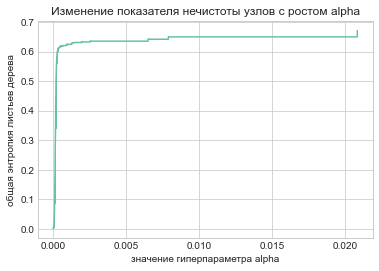

In [21]:
# изображаем на графике
plt.plot(ccp_alphas[:-1], impurities[:-1], marker=',', drawstyle="steps-post")
plt.xlabel("значение гиперпараметра alpha")
plt.ylabel("общая энтропия листьев дерева")
plt.title("Изменение показателя нечистоты узлов с ростом alpha")
plt.show()

In [22]:
# обучающая и тестовая выборки, чтобы сэкономить время
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=my_seed)

# модели
clfs = list()

# таймер
tic = time.perf_counter()
# цикл по значениям alpha
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=my_seed, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# таймер
toc = time.perf_counter()
print(f"Расчёты по обрезке дерева заняли {toc - tic:0.2f} секунд")

Расчёты по обрезке дерева заняли 538.35 секунд


In [23]:
# извлекаем характеристики глубины и точности
#  таймер
tic = time.perf_counter()
node_counts = [clf.tree_.node_count for clf in clfs]
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
#  таймер
toc = time.perf_counter()
print(f"Расчёты показателей точности заняли {toc - tic:0.2f} секунд")

Расчёты показателей точности заняли 12.66 секунд


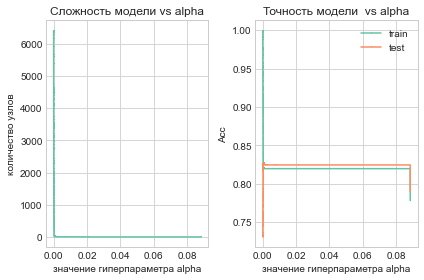

In [24]:
# изображаем на графике
fig, ax = plt.subplots(1, 2)

# график глубины дерева
ax[0].plot(ccp_alphas, node_counts, marker=',', drawstyle="steps-post")
ax[0].set_xlabel("значение гиперпараметра alpha")
ax[0].set_ylabel("количество узлов")
ax[0].set_title("Сложность модели vs alpha")

# график точности
ax[1].plot(ccp_alphas, train_scores, marker=',', label='train',
           drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores, marker=',', label='test',
           drawstyle="steps-post")
ax[1].set_xlabel("значение гиперпараметра alpha")
ax[1].set_ylabel("Acc")
ax[1].set_title("Точность модели  vs alpha")
ax[1].legend()
fig.tight_layout()

Находим оптимальный размер дерева по максимуму $Acc$ на тестовой выборке.  

In [25]:
# оптимальное количество узлов
opt_nodes_num = node_counts[test_scores.index(max(test_scores))]

# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=clfs[opt_nodes_num], X=X, y=y, cv=5,
                    scoring='accuracy')

# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('pruned_tree')

print('Оптимальное количество узлов:', opt_nodes_num,
      '\nсоответствующая Acc на тестовой:', np.around(max(test_scores), 3),
      '\n\nAcc с перекрёстной проверкой',
      '\nдля модели', score_models[1], ':', score[1])

Оптимальное количество узлов: 23 
соответствующая Acc на тестовой: 0.827 

Acc с перекрёстной проверкой 
для модели pruned_tree : 0.731


Посмотрим на характеристики глубины и сложности построенного дерева с обрезкой ветвей.

In [26]:
# выводим количество листьев (количество узлов)
clfs[opt_nodes_num].get_n_leaves()

2789

In [27]:
# глубина дерева: количество узлов от корня до листа
#  в самой длинной ветви
clfs[opt_nodes_num].get_depth()

43

---

📚 **Пример визуализации небольшого дерева**

Лучшее дерево с обрезкой по-прежнему слишком велико для визуализации. Для примера нарисуем одно из небольших деревьев с обрезкой и выведем его же в виде текста.  

In [28]:
# находим деревья с количеством листьев меньше 20
[i for i in node_counts if i < 20]

[19, 17, 17, 17, 17, 17, 15, 11, 11, 11, 9, 9, 9, 9, 7, 5, 5, 3, 1]

Количество узлов: 19 
Точность дерева на тестовой: 0.826


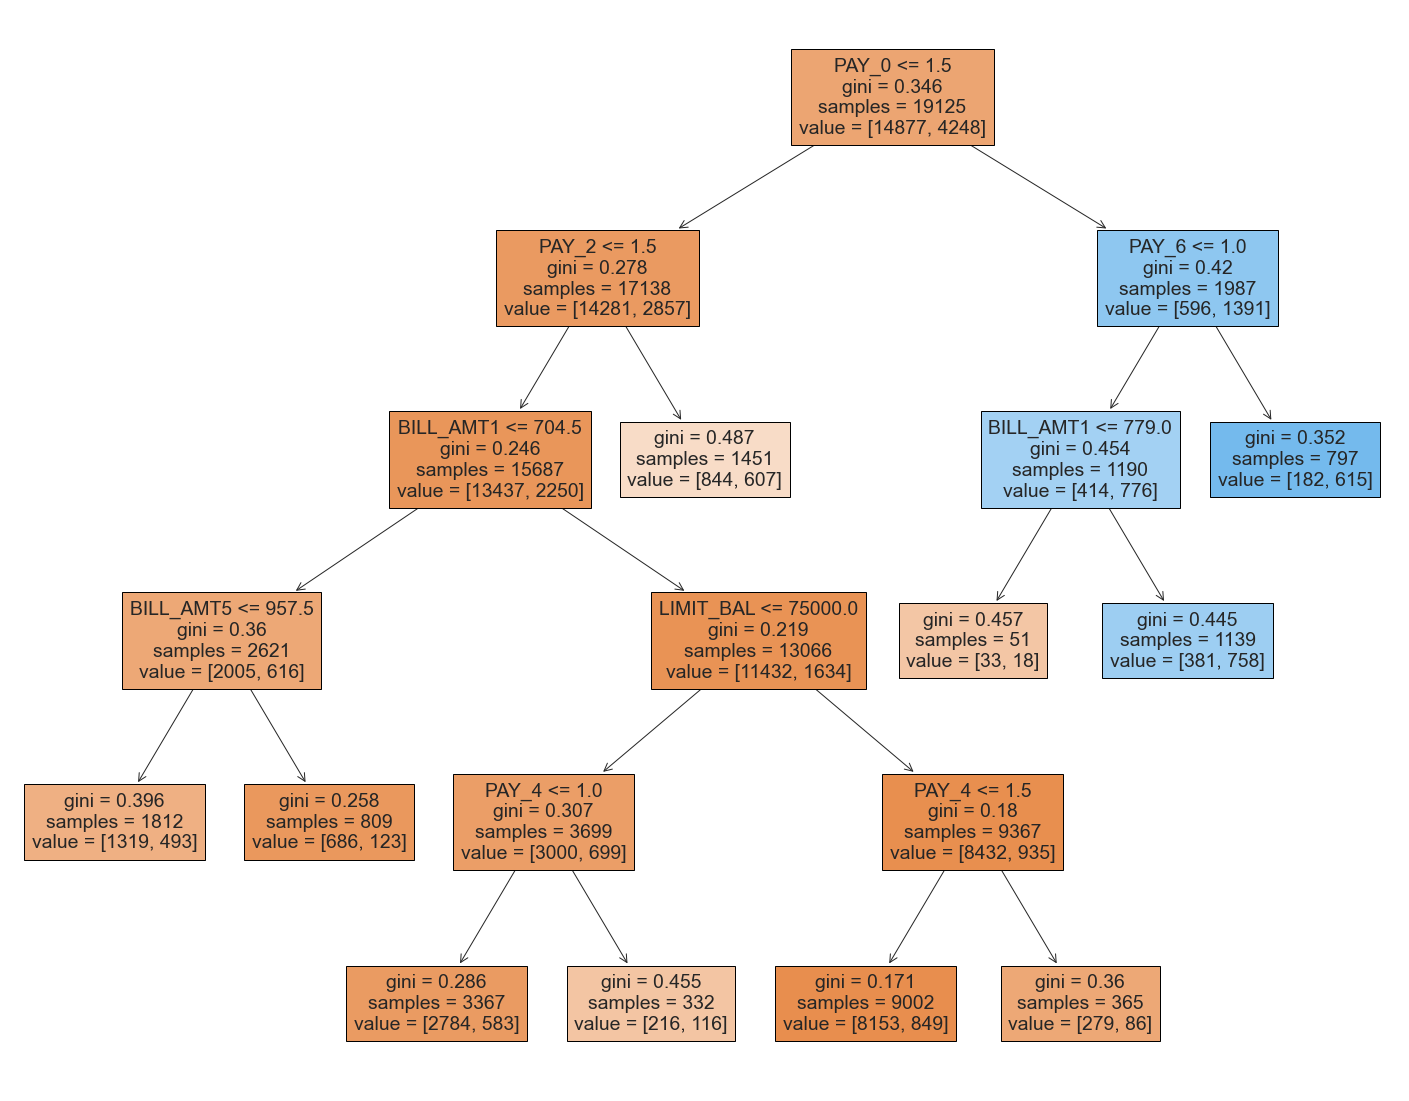

In [29]:
# визуализация на схеме НА ПРИМЕРЕ МАЛЕНЬКОГО ДЕРЕВА
nodes_num = len([i for i in node_counts if i < 20])
print('Количество узлов:', nodes_num,
      '\nТочность дерева на тестовой:', 
      np.around(test_scores[node_counts.index(nodes_num)], 3))

fig = plt.figure(figsize=(25,20))
_ = plot_tree(clfs[node_counts.index(nodes_num)], 
              filled=True, 
              feature_names=list(X.columns))

In [30]:
# визуализируем дерево в виде текстовой схемы
viz = export_text(clfs[node_counts.index(nodes_num)], 
                  feature_names=list(X.columns))
print(viz)

|--- PAY_0 <= 1.50
|   |--- PAY_2 <= 1.50
|   |   |--- BILL_AMT1 <= 704.50
|   |   |   |--- BILL_AMT5 <= 957.50
|   |   |   |   |--- class: 0
|   |   |   |--- BILL_AMT5 >  957.50
|   |   |   |   |--- class: 0
|   |   |--- BILL_AMT1 >  704.50
|   |   |   |--- LIMIT_BAL <= 75000.00
|   |   |   |   |--- PAY_4 <= 1.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- PAY_4 >  1.00
|   |   |   |   |   |--- class: 0
|   |   |   |--- LIMIT_BAL >  75000.00
|   |   |   |   |--- PAY_4 <= 1.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- PAY_4 >  1.50
|   |   |   |   |   |--- class: 0
|   |--- PAY_2 >  1.50
|   |   |--- class: 0
|--- PAY_0 >  1.50
|   |--- PAY_6 <= 1.00
|   |   |--- BILL_AMT1 <= 779.00
|   |   |   |--- class: 0
|   |   |--- BILL_AMT1 >  779.00
|   |   |   |--- class: 1
|   |--- PAY_6 >  1.00
|   |   |--- class: 1



---

# Бэггинг  

Модель бэггинга использует бутстреп, чтобы вырастить $B$ деревьев на выборках с повторами из обучающих данных. Построим модель для $B=40$ деревьев.  

In [31]:
# параметр B: количество деревьев
num_trees = 40

# разбиения для перекрёстной проверки
kfold = KFold(n_splits=5, random_state=my_seed, shuffle=True)

# таймер
tic = time.perf_counter()
# модель с бэггингом
tree_bag = BaggingClassifier(base_estimator=cls_one_tree,
                             n_estimators=num_trees,
                             random_state=my_seed)

cv = cross_val_score(tree_bag, X, y, cv=kfold)

# таймер
toc = time.perf_counter()
print(f"Обучение модели с бэггингом на {num_trees:0.0f} деревьях", 
      " и перекрёстной проверкой ", 
      f"заняло {toc - tic:0.2f} секунд", sep='')

Обучение модели с бэггингом на 40 деревьях и перекрёстной проверкой заняло 57.58 секунд


In [32]:
# точность
np.around(np.mean(cv), 3)

0.811

Итак, мы построили модель, выбрав параметр $B$ случайным образом. Воспользуемся функцией `GridSearchCV()`, чтобы перебрать 8 вариантов значений для параметра $B$.  

In [33]:
# настроим параметры бэггинга с помощью сеточного поиска
param_grid = {'n_estimators' : [5, 10, 15, 25, 30, 40, 50, 60]}

# таймер
tic = time.perf_counter()
clf = GridSearchCV(BaggingClassifier(DecisionTreeClassifier()),
                  param_grid, scoring='accuracy', cv=kfold)

tree_bag = clf.fit(X, y)
# таймер
toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:0.2f} секунд", sep='')

Сеточный поиск занял 240.27 секунд


In [34]:
# точность лучшей модели
np.around(tree_bag.best_score_, 3)

0.812

In [35]:
# количество деревьев у лучшей модели
tree_bag.best_params_

{'n_estimators': 40}

In [36]:
tree_bag.best_estimator_.get_params()

{'base_estimator__ccp_alpha': 0.0,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': None,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(),
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 40,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Таким образом, перебрав несколько вариантов для $B$, мы немного улучшили первоначальную точность модели бэггинга.  

In [37]:
# записываем точность
score.append(np.around(tree_bag.best_score_, 3))
score_models.append('bagging_GS')

print('Acc с перекрёстной проверкой',
      '\nдля модели', score_models[2], ':', score[2])

Acc с перекрёстной проверкой 
для модели bagging_GS : 0.812



# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.  

In [38]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,one_tree,0.731
1,pruned_tree,0.731
2,bagging_GS,0.812


Все модели показывают среднюю точность по показателю $Acc$, при этом самой точной оказывается модель Бэггинга. Сделаем прогноз на отложенные наблюдения.   

In [39]:
# данные для прогноза
X_pred = DF_predict_num.drop(['Y'], axis=1)
# строим прогноз
y_hat = tree_bag.best_estimator_.predict(X_pred)
# характеристики точности
print(classification_report(DF_predict_num['Y'], y_hat))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      3454
           1       0.66      0.37      0.48      1046

    accuracy                           0.81      4500
   macro avg       0.75      0.66      0.68      4500
weighted avg       0.79      0.81      0.79      4500

